In [1]:
import menpo.io as mio
from menpo.transform import AlignmentSimilarity
from menpo.shape import PointCloud
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from menpowidgets import visualize_images, visualize_fitting_result
from menpofit.transform import DifferentiableThinPlateSplines as tps
import numpy as np
import itertools
from menpo.image import Image
from menpowidgets import plot_ced
from menpofit.error import euclidean_distance_normalised_error
from menpofit.visualize import plot_cumulative_error_distribution
from menpofit.fitter import noisy_shape_from_shape, noisy_target_alignment_transform
from menpo.visualize import print_dynamic
from dAAMs import dAAMs
from menpofit.aam import HolisticAAM, PatchAAM
from menpo.visualize import print_dynamic
from menpofit.sdm import RegularizedSDM
from menpofit.aam.base import compute_reference_shape
from menpo.feature import igo, hog, no_op, double_igo as digo, dsift, fast_dsift, hellinger_vector_128_dsift
from dAAMs.tools import group_from_labels, sift_svs_shape, hog_svs_shape, distance_transform_shape, deprocess_image
shog = lambda x: hog(x, cell_size=2, block_size=2)
# from menpo.landmark import labeller, svs_face_68, ear_55
%matplotlib inline

/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #d


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/homes/yz4009/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/cuda_ndarray', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/theano/sandbox/cuda', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/numpy/core/include', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/include/python3.5m', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/theano/gof', '-L/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib', '-o', '/homes/yz4009/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.5m', '-lcudart']


WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)
Using Theano backend.


#### model config

In [2]:
n_levels = 3
n_shape = [5,8,13]
scales = (0.25, 0.5, 1.0)
n_appearance = 0.9
max_iters = 50
diagonal=200
f = no_op
patch_shape=[(9, 9),(13, 13),(17, 17)]

#### build model

#### load model

#### helper functions

In [3]:
def img_align(img):
    warp_transform = DifferentiablePiecewiseAffine(reference_frame.landmarks['source'].lms,
                               img.landmarks['PTS'].lms)
    
    warped_i = img.warp_to_mask(reference_frame.mask, warp_transform,
                                  warp_landmarks=False)
    # attach reference frame landmarks to images
    warped_i.landmarks['PTS'] = reference_frame.landmarks['source']
    
    
    return warped_i

In [4]:
def bb_from_shape(shape, boundary=10):
    h,w = shape
    return PointCloud(np.array([[boundary,boundary],[h-boundary,boundary],[boundary,w-boundary],[h-boundary,w-boundary]])).bounding_box()

In [5]:
def cnn_patch_feature(patches):
    img_shape = patches.shape[2:]
    return np.array([cnn_feature(Image(pimg)) for pimg in patches.reshape((-1,)+img_shape)])

In [6]:
def chunk(seq, num):
  avg = len(seq) / float(num)
  out = []
  last = 0.0

  while last < len(seq):
    out.append(seq[int(last):int(last + avg)])
    last += avg

  return out

In [7]:
from menpo.model import PCAModel, PCAVectorModel
def pca_mapping(datas, ratio=0.90):
    pca = PCAVectorModel(datas)
    pca.n_active_components = np.argwhere(pca.eigenvalues_cumulative_ratio() > ratio)[0][0]
    return [pca.project(vec) for vec in datas]

### WPUTEDB

### Recognition

### data preparation

#### ear feature extraction

In [8]:
from dAAMs.tools import cnn_feature
from menpo.image import Image
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/')):
    mio.export_pickle(cnn_feature(i, layer_name='cov5_1').ravel(), '{}/{}+deep.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [9]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/aligned/')):
    mio.export_pickle(cnn_feature(i, layer_name='cov5_1').ravel(), '{}/{}+deep.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [12]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/')):
    mio.export_pickle(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in i.extract_patches_around_landmarks()]), '{}/{}+128dsift.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/aligned/')):
    mio.export_pickle(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in i.extract_patches_around_landmarks()]), '{}/{}+128dsift.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [6]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/')):
    feature = []
    for s,ps in zip(scales,patch_shape):
        timg = i.rescale(s)
        feature.append(dsift(timg).extract_patches_around_landmarks(group='PTS', patch_shape=ps).ravel())
        feature.append(timg.landmarks['PTS'].lms.points.ravel())
    features = np.concatenate(feature)
    mio.export_pickle(features, '{}/{}+PEP.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [13]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/')):
    feature = []
    for s,ps in zip(scales,patch_shape):
        timg = i.rescale(s)
        feature.append(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in timg.extract_patches_around_landmarks()]))
        feature.append(timg.landmarks['PTS'].lms.points.ravel())
    features = np.concatenate(feature)
    mio.export_pickle(features, '{}/{}+PEP128.pkl'.format(i.path.parent, i.path.stem), overwrite=True)
    
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/aligned/')):
    feature = []
    for s,ps in zip(scales,patch_shape):
        timg = i.rescale(s)
        feature.append(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in timg.extract_patches_around_landmarks()]))
        feature.append(timg.landmarks['PTS'].lms.points.ravel())
    features = np.concatenate(feature)
    mio.export_pickle(features, '{}/{}+PEP128.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [3]:
!ls -l /homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/*PEP.pkl | wc -l

ls: cannot access '/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/*PEP.pkl': No such file or directory
0


In [ ]:
# img_datas = []
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/')):
    mio.export_pickle(dsift(i).pixels.ravel(), '{}/{}+dsift.pkl'.format(i.path.parent, i.path.stem), overwrite=True)
#     img_datas.append(dsift(i).pixels.ravel())
#     img_datas.append(dsift(img_align(i)).pixels.ravel())
#     img = i.resize((225,225))
#     feature = []
#     for s,ps in zip(scales,patch_shape):
#         timg = img.rescale(s)
#         feature.append(dsift(timg).extract_patches_around_landmarks(group='PTS', patch_shape=ps).ravel())
#         feature.append(timg.landmarks['PTS'].lms.points.ravel())
#     features = np.concatenate(feature)
#     img_datas.append(features)
#     print_dynamic(j)
#     img_datas.append(i)
    

In [ ]:
images[0].shape

#### data without ear

In [3]:
data = mio.import_pickle('/homes/yz4009/wd/databases/ear/WPUTEDB/labeled_image.pkl', encoding='latin1')

label,images = list(zip(*data))

for i in images:
    if i.path.stem[7] == 'L':
        i.landmarks['PTS'] = i.mirror().landmarks['PTS'].lms

In [13]:
img_datas = []

In [16]:
for i in images[50:50+50]:
    mimg = i.as_masked()
    mimg = mimg.constrain_mask_to_landmarks()
    cimg = i.copy()
    cimg.pixels[mimg.mask.pixels] = 0
    img_datas.append(cimg)

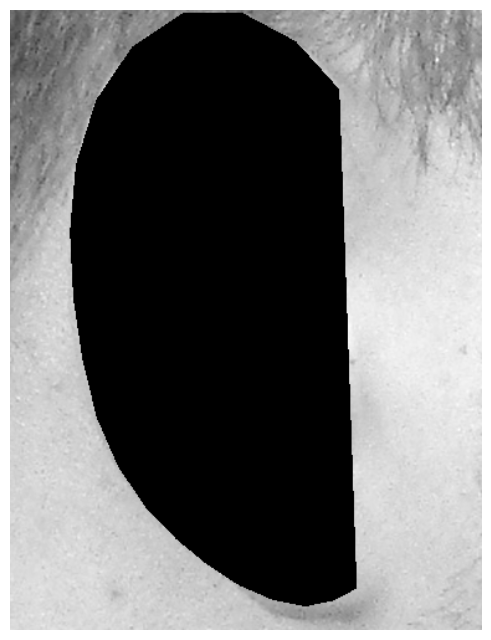

In [17]:
visualize_images(img_datas)

In [58]:
data = zip(labels, images)

In [25]:
vggimages = mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/011*')
cimgs = []
for i in vggimages:
    mimg = i.as_masked()
    mimg = mimg.constrain_mask_to_landmarks(group='PTS')
    cimg = i.copy()
    cimg.pixels[mimg.mask.pixels == True] = 0
    cimgs.append(cimg)

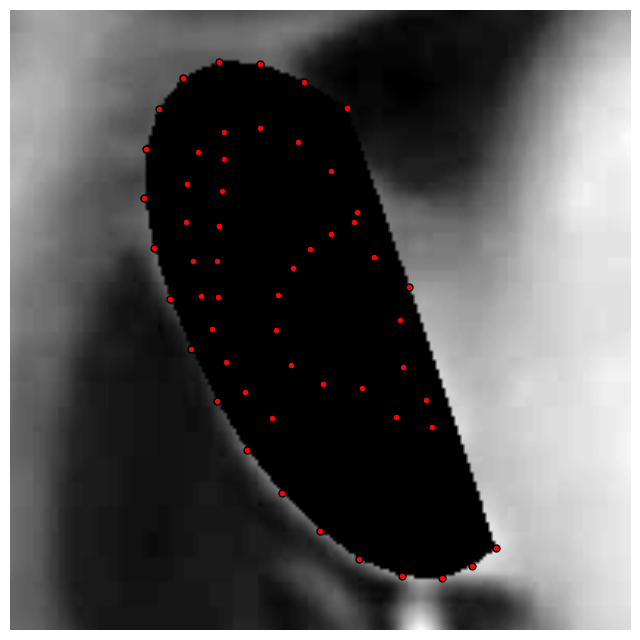

In [26]:
visualize_images(cimgs)

In [12]:
from workerbee import JobSet
import menpo.io as mio
import numpy as np
from pathlib import Path

wd_path = '/vol/atlas/homes/yz4009'
db_path = '/homes/yz4009/wd/databases/ear/WPUTEDB'
jobname = 'cnn_patch_features'

js = JobSet(jobname,host='db.doc.ic.ac.uk',user='yz4009',password='1330871Pp',dbname='yz4009')
js.setup_jobset(ignore_existing_jobset=True)

for fr in mio.import_pickles(db_path + '/*_fr.pkl'):
    js.add_jobs([{'path':str(fr.path).replace('/homes/yz4009/wd',wd_path)}])
    

INFO     (2016-09-12 16:06:47): Found Postgresql version 9.2.10 - Using JSON as the data type for the input_data field.
WARNING  (2016-09-12 16:06:47): Table already exists for jobset 'cnn_patch_features' - but ignoring
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 jobs
INFO     (2016-09-12 16:06:47): Submitted 1 j

In [ ]:
from dAAMs.tools import denseCNN, cnn_feature
from pathlib import Path
import menpo.io as mio
from menpo.image import Image
import numpy as np
from menpofit.aam import LucasKanadeAAMFitter


def cnn_patch_feature(patches):
    img_shape = patches.shape[2:]
    return np.array([cnn_feature(Image(pimg)) for pimg in patches.reshape((-1,)+img_shape)])


def func(args):

    
    fr_path = args['path']
    p = Path(fr_path)
    fr = mio.import_pickle(fr_path)

    img = fr.image
    img.landmarks['PTS'] = fr.final_shape

    feature = cnn_patch_feature(img.rescale_to_diagonal(200).extract_patches_around_landmarks(group='PTS', patch_shape=(17,17))).ravel()

    mio.export_pickle(feature, '{}/{}_cnn_patch.pkl'.format(p.parent, p.stem), overwrite=True)

    return

In [2]:
images = mio.import_images('/vol/atlas/databases/cats/images/')

In [5]:
visualize_images(images)

Initializing...


/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/ipywidgets/widgets/widget_string.py:55: UserWarning: The Latex widget is deprecated. Use Label instead
  warn('The Latex widget is deprecated. Use Label instead')


TraitError: The 'box_style' trait of a ColourSelectionWidget instance must be any of ['success', 'info', 'warning', 'danger', ''], but a value of None <class 'NoneType'> was specified.

In [15]:
for j,(l,img) in enumerate(mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/VGGEAR-bound.pkl', encoding='latin1')):
    mio.export_image(img,'/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/{:03d}-{:04d}.jpg'.format(l,j))
    mio.export_landmark_file(img.landmarks['PTS'],'/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/{:03d}-{:04d}.pts'.format(l,j))